In [5]:
import yfinance as yf
import requests
import pandas as pd
import os
import numpy as np
import finagg
from sklearn import metrics
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


aapl = yf.Ticker("AAPL")


In [6]:
from xgboost import XGBClassifier

In [7]:
import os
%env FRED_API_KEY=132fd821d28cc6d23c32eeea74e5fe86


env: FRED_API_KEY=132fd821d28cc6d23c32eeea74e5fe86


In [8]:
def returns_from_positions(position_data, df_rtn):
    return (position_data * df_rtn).sum(axis=1)#/ (position_data.abs().sum(axis=1))

In [9]:
df = pd.read_csv("SignalDoc.csv")

In [10]:
#df1 = pd.read_csv("Firm Level Characteristics/Full Sets/signed_predictors_dl_wide.csv")

df1 = pd.read_csv("1960-1970features.csv")

In [11]:
df1['yyyymm'] = pd.to_datetime(df1['yyyymm'],format = "%Y%m")
df1['yyyymm'] = df1['yyyymm'].apply(lambda dt: dt.replace(day=1))

In [12]:
df_returns = pd.read_csv("1960-2023returns.csv")

In [13]:
df_returns['date'] = pd.to_datetime(df_returns["date"])

In [14]:
df_returns['date'] = df_returns['date'].apply(lambda dt: dt.replace(day=1))

In [15]:
xgc = XGBClassifier()

In [16]:
df_returns = df_returns.sort_values(by = "date")
df_returns_train = df_returns[df_returns["date"] <= "1970-01-01"]


In [17]:
#rank each month
df_returns_train.rename(columns={"PERMNO": "permno"}, inplace=True)


/var/folders/sz/ts8tdp9n3f133bj7r6__4w7h0000gn/T/ipykernel_38699/3500637321.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_returns_train.rename(columns={"PERMNO": "permno"}, inplace=True)


In [18]:
df_recent_train = pd.read_csv("2000-2010Training.csv")
df_recent_returns_train = df_returns[df_returns["date"] >= "2000-01-01"]
df_recent_returns_train =  df_returns[df_returns["date"]<="2009-12-01"]
df_recent_train['yyyymm'] = pd.to_datetime(df_recent_train['yyyymm'],format = "%Y%m")
df_recent_train['yyyymm'] = df_recent_train['yyyymm'].apply(lambda dt: dt.replace(day=1))
df_recent_returns_train.rename(columns={"PERMNO":"permno"}, inplace=True)

/var/folders/sz/ts8tdp9n3f133bj7r6__4w7h0000gn/T/ipykernel_38699/3232823481.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recent_returns_train.rename(columns={"PERMNO":"permno"}, inplace=True)


In [19]:
df_recent_train.rename(columns={'yyyymm': 'date'}, inplace=True)
intersection_df_recent = pd.merge(df_recent_train, df_recent_returns_train, how='inner', on=['permno', 'date'])
intersection_df_recent['Year'] = intersection_df_recent['date'].dt.year
intersection_df_recent['Month'] = intersection_df_recent['date'].dt.month
intersection_df_recent['RET'] = pd.to_numeric(intersection_df_recent["RET"], errors='coerce')
intersection_df_recent['Quintile'] = intersection_df_recent.groupby(['Year', 'Month'])['RET'].transform(
    lambda x: pd.qcut(x, 5, labels=False)
)
intersection_df_recent = intersection_df_recent.sort_values(by=["permno", "date"])
intersection_df_recent["New Y"] = intersection_df_recent.groupby(["permno"])["Quintile"].shift(-1)

#intersection_df_recent.dropna(subset = ['Quintile'], inplace=True)
intersection_df_recent.dropna(subset = ['New Y'], inplace=True)
drop_from_df = ["permno", "date", "RET", "RETX", "Quintile", "Year", "Month", "Unnamed: 0", "New Y"]
Y_recent = intersection_df_recent["New Y"]
X_recent = intersection_df_recent.drop(columns=drop_from_df)

In [20]:
#first year out of sample
df2010 = pd.read_csv("2010Test.csv")
df2010RET = df_returns[df_returns["date"] >= "2010-01-01"]
df2010RET =  df2010RET[df_returns["date"]<="2010-12-01"]
df2010['yyyymm'] = pd.to_datetime(df2010['yyyymm'],format = "%Y%m")
df2010['yyyymm'] = df2010['yyyymm'].apply(lambda dt: dt.replace(day=1))
df2010RET.rename(columns={"PERMNO":"permno"}, inplace=True)
df2010.drop(df2010.columns[len(df2010.columns)-1], axis=1, inplace=True)

/var/folders/sz/ts8tdp9n3f133bj7r6__4w7h0000gn/T/ipykernel_38699/3650907498.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2010RET =  df2010RET[df_returns["date"]<="2010-12-01"]


In [21]:
df2010.rename(columns={'yyyymm': 'date'}, inplace=True)
intersection_df_2010 = pd.merge(df2010, df2010RET, how='inner', on=['permno', 'date'])
intersection_df_2010['Year'] = intersection_df_2010['date'].dt.year
intersection_df_2010['Month'] = intersection_df_2010['date'].dt.month
intersection_df_2010['RET'] = pd.to_numeric(intersection_df_2010["RET"], errors='coerce')
intersection_df_2010['Quintile'] = intersection_df_2010.groupby(['Year', 'Month'])['RET'].transform(
    lambda x: pd.qcut(x, 5, labels=False)
)
intersection_df_2010 = intersection_df_2010.sort_values(by=["permno", "date"])
intersection_df_2010["New Y"] = intersection_df_2010.groupby(["permno"])["Quintile"].shift(-1)

intersection_df_2010.dropna(subset = ['New Y'], inplace=True)
#intersection_df_2010.dropna(subset = ['Quintile'], inplace=True)
drop_from_df = ["permno", "date", "RET", "RETX", "Quintile", "Year", "Month", "Unnamed: 0", "New Y"]
Y_2010 = intersection_df_2010["New Y"]
X_2010 = intersection_df_2010.drop(columns=drop_from_df)

In [22]:
#data cleaning, merging returns and features datasets
def to_intersect(file, df_returns):
    df = pd.read_csv(file)
    df['yyyymm'] = pd.to_datetime(df['yyyymm'],format = "%Y%m")
    df['yyyymm'] = df['yyyymm'].apply(lambda dt: dt.replace(day=1))
    dfRET = df_returns[df_returns["date"] >= df['yyyymm'].min()]
    dfRET =  dfRET[df_returns["date"]<=df['yyyymm'].max()]
    dfRET.rename(columns={"PERMNO":"permno"}, inplace=True)
    #df.drop(df.columns[len(df.columns)-1], axis=1, inplace=True)
    df.rename(columns={'yyyymm': 'date'}, inplace=True)
    intersection = pd.merge(df, dfRET, how='inner', on=['permno', 'date'])
    intersection['Year'] = intersection['date'].dt.year
    intersection['Month'] = intersection['date'].dt.month
    intersection['RET'] = pd.to_numeric(intersection["RET"], errors='coerce')
    intersection['Quintile'] = intersection.groupby(['Year', 'Month'])['RET'].transform(
        lambda x: pd.qcut(x, 5, labels=False)
    )
    intersection = intersection.sort_values(by=["permno", "date"])
    intersection["New Y"] = intersection.groupby(["permno"])["Quintile"].shift(-1)
    intersection.dropna(subset = ['New Y'], inplace=True)
    intersection["New RET"] = intersection.groupby(["permno"])["RET"].shift(-1)
    intersection.dropna(subset = ["New RET"], inplace=True)
    return intersection
    


In [23]:
#translating merged dataset into a X and Y dataset
def to_X_Y(intersect):
    intersect.dropna(subset = ['New Y'], inplace=True)
    drop_from_df = ["permno", "date", "RET", "RETX", "Quintile", "Year", "Month", "Unnamed: 0", "New Y", "New RET"]
    Y = intersect["New Y"]
    X = intersect.drop(columns=drop_from_df)
    return [X, Y]

In [24]:
#calculating returns by taking positions in different ways based off our predictions
def gen_returns(intersect, Y_pred):
    intersect.insert(0, "Positions", take_positions(intersect, Y_pred), False)
    pivoted = intersect.pivot_table(index='date', columns='permno', values='Positions', aggfunc='mean')
    pivoted_ret = intersect.pivot_table(index='date', columns='permno', values='New RET', aggfunc='mean')
    return returns_from_positions(pivoted, pivoted_ret)

def gen_returns_biased(intersect, Y_pred):
    intersect.insert(0, "Positions", take_positions_biased(intersect, Y_pred), False)
    pivoted = intersect.pivot_table(index='date', columns='permno', values='Positions', aggfunc='mean')
    pivoted_ret = intersect.pivot_table(index='date', columns='permno', values='New RET', aggfunc='mean')
    return returns_from_positions(pivoted, pivoted_ret)

def gen_returns_ranked(intersect, Y_pred):
    intersect.insert(0, "Positions", take_positions_ranked(intersect, Y_pred), False)
    pivoted = intersect.pivot_table(index='date', columns='permno', values='Positions', aggfunc='mean')
    pivoted_ret = intersect.pivot_table(index='date', columns='permno', values='New RET', aggfunc='mean')
    return returns_from_positions(pivoted, pivoted_ret)

In [25]:
#calculate sharpe ratio
def sharpe_ratio(monthly_return_series):
    return round(monthly_return_series.mean() / monthly_return_series.std() * 12**0.5, 2)

In [26]:
def drawdown(port_value):
    return round((max(port_value) - min(port_value)) / max(port_value), 2)

In [27]:
X_Y_2011 = to_X_Y(to_intersect("2011Test.csv", df_returns))
X_Y_2012 = to_X_Y(to_intersect("2012Test.csv", df_returns))
X_Y_2013 = to_X_Y(to_intersect("2013Test.csv", df_returns))
X_Y_2014 = to_X_Y(to_intersect("2014Test.csv", df_returns))
X_Y_2015 = to_X_Y(to_intersect("2015Test.csv", df_returns))
X_Y_2016 = to_X_Y(to_intersect("2016Test.csv", df_returns))
X_Y_2017 = to_X_Y(to_intersect("2017Test.csv", df_returns))
X_Y_2018 = to_X_Y(to_intersect("2018Test.csv", df_returns))
X_Y_2019 = to_X_Y(to_intersect("2019Test.csv", df_returns))
X_Y_2020 = to_X_Y(to_intersect("2020Test.csv", df_returns))
X_Y_2021 = to_X_Y(to_intersect("2021Test.csv", df_returns))
X_Y_2022 = to_X_Y(to_intersect("2022Test.csv", df_returns))
X_Y_2023 = to_X_Y(to_intersect("2023Test.csv", df_returns))

X_Ys = [X_Y_2011, X_Y_2012, X_Y_2013, X_Y_2014, X_Y_2015, X_Y_2016, X_Y_2017, X_Y_2018, X_Y_2019, X_Y_2020, X_Y_2021, X_Y_2022, X_Y_2023]


/var/folders/sz/ts8tdp9n3f133bj7r6__4w7h0000gn/T/ipykernel_38699/1325193076.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfRET =  dfRET[df_returns["date"]<=df['yyyymm'].max()]
/var/folders/sz/ts8tdp9n3f133bj7r6__4w7h0000gn/T/ipykernel_38699/1325193076.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfRET =  dfRET[df_returns["date"]<=df['yyyymm'].max()]
/var/folders/sz/ts8tdp9n3f133bj7r6__4w7h0000gn/T/ipykernel_38699/1325193076.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfRET =  dfRET[df_returns["date"]<=df['yyyymm'].max()]
/var/folders/sz/ts8tdp9n3f133bj7r6__4w7h0000gn/T/ipykernel_38699/1325193076.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfRET =  dfRET[df_returns["date"]<=df['yyyymm'].max()]
/var/folders/sz/ts8tdp9n3f133bj7r6__4w7h0000gn/T/ipykernel_38699/1325193076.py:7: UserWarning: Boolean Series key will be reindexed to match

In [28]:
xgc_recent = XGBClassifier()
xgc_recent.fit(X_recent, Y_recent)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [29]:
Y_2011_pred = xgc_recent.predict(X_Y_2011[0])
Y_2012_pred = xgc_recent.predict(X_Y_2012[0])
Y_2013_pred = xgc_recent.predict(X_Y_2013[0])
Y_2014_pred = xgc_recent.predict(X_Y_2014[0])
Y_2015_pred = xgc_recent.predict(X_Y_2015[0])
Y_2016_pred = xgc_recent.predict(X_Y_2016[0])
Y_2017_pred = xgc_recent.predict(X_Y_2017[0])
Y_2018_pred = xgc_recent.predict(X_Y_2018[0])
Y_2019_pred = xgc_recent.predict(X_Y_2019[0])
Y_2020_pred = xgc_recent.predict(X_Y_2020[0])
Y_2021_pred = xgc_recent.predict(X_Y_2021[0])
Y_2022_pred = xgc_recent.predict(X_Y_2022[0])
Y_2023_pred = xgc_recent.predict(X_Y_2023[0])
m11 = metrics.accuracy_score(Y_2011_pred, X_Y_2011[1])
m12 = metrics.accuracy_score(Y_2012_pred, X_Y_2012[1])
m13 = metrics.accuracy_score(Y_2013_pred, X_Y_2013[1])
m14 = metrics.accuracy_score(Y_2014_pred, X_Y_2014[1])
m15 = metrics.accuracy_score(Y_2015_pred, X_Y_2015[1])
m16 = metrics.accuracy_score(Y_2016_pred, X_Y_2016[1])
m17 = metrics.accuracy_score(Y_2017_pred, X_Y_2017[1])
m18 = metrics.accuracy_score(Y_2018_pred, X_Y_2018[1])
m19 = metrics.accuracy_score(Y_2019_pred, X_Y_2019[1])
m20 = metrics.accuracy_score(Y_2020_pred, X_Y_2020[1])
m21 = metrics.accuracy_score(Y_2021_pred, X_Y_2021[1])
m22 = metrics.accuracy_score(Y_2022_pred, X_Y_2022[1])
m23 = metrics.accuracy_score(Y_2023_pred, X_Y_2023[1])


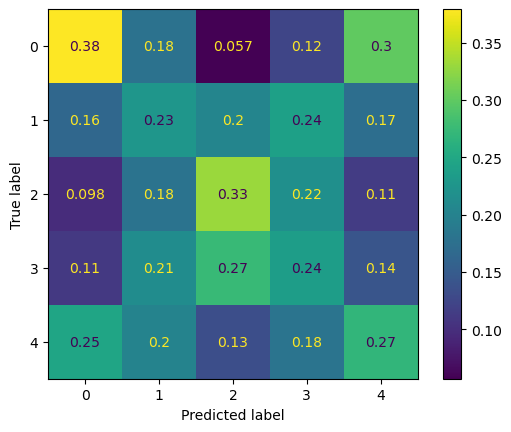

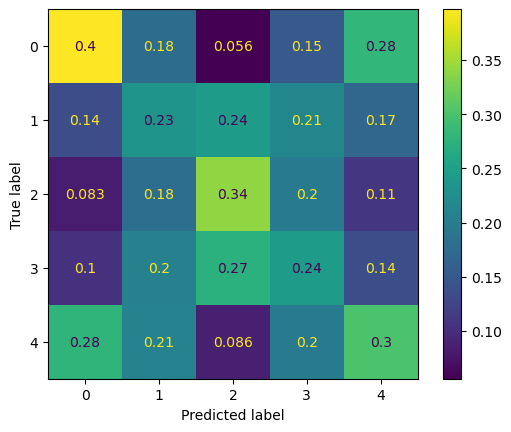

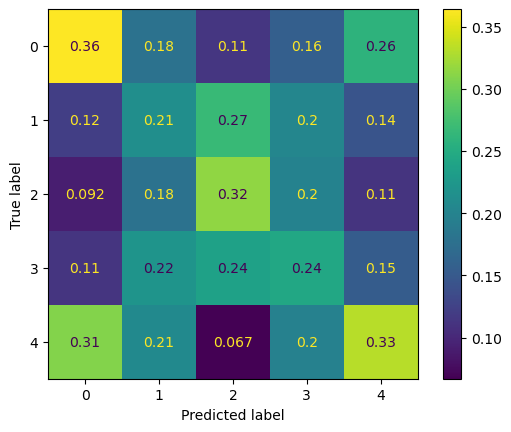

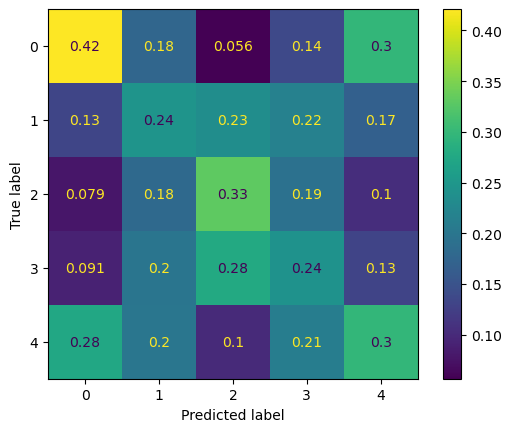

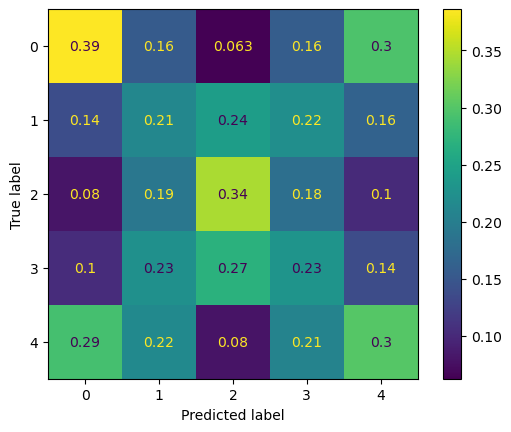

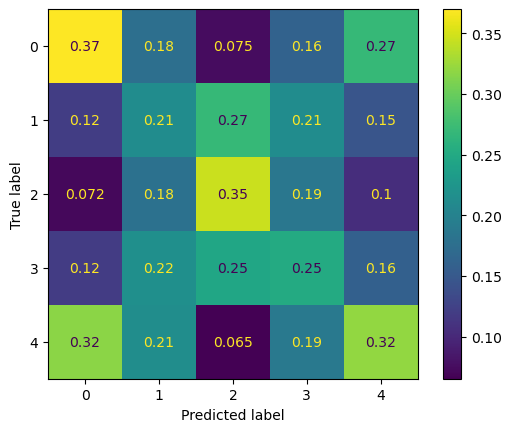

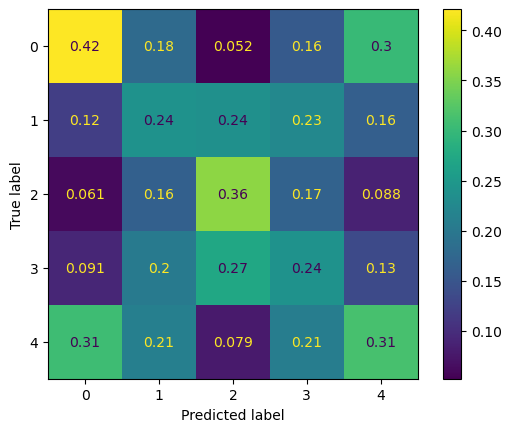

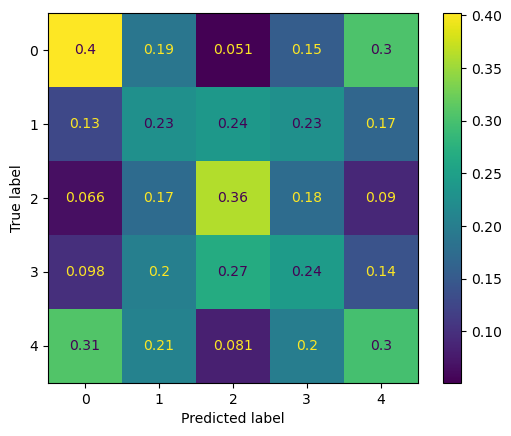

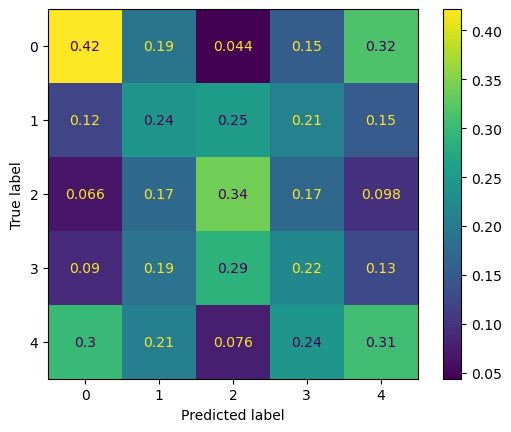

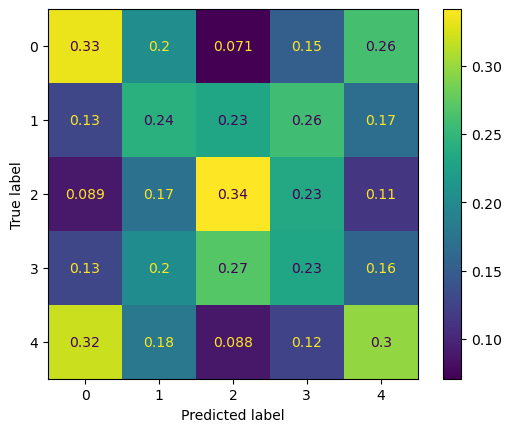

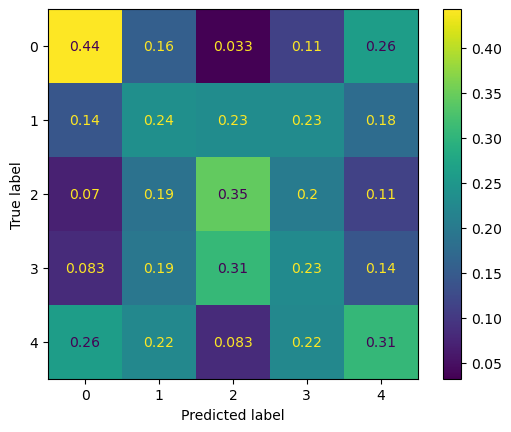

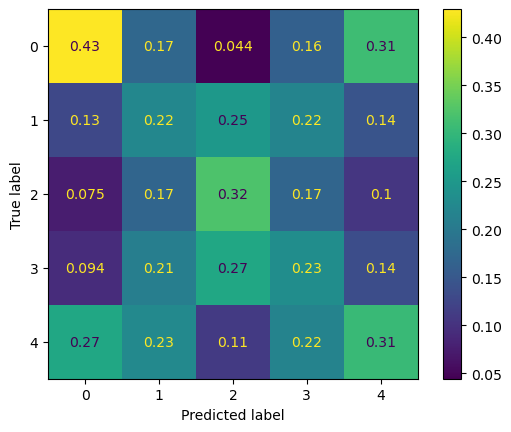

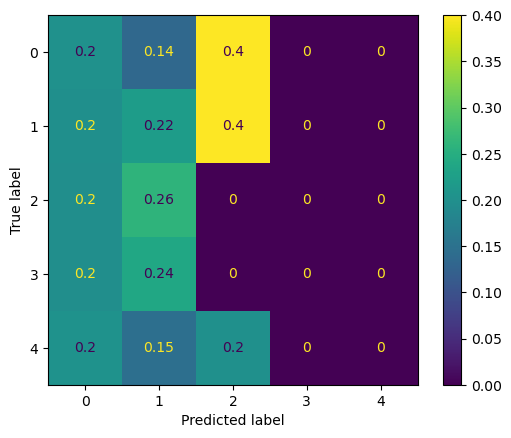

In [30]:
Y_preds = [Y_2011_pred, Y_2012_pred, Y_2013_pred, Y_2014_pred, Y_2015_pred, Y_2016_pred, Y_2017_pred, Y_2018_pred, Y_2019_pred, Y_2020_pred, Y_2021_pred, Y_2022_pred, Y_2023_pred]
c_mats =[]
c_mats_true=[]
for i in range(0, 13):
    cm = confusion_matrix(X_Ys[i][1], Y_preds[i], normalize='pred')
    c_mats.append(cm)
    dis = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
    dis.plot()
    plt.show()

for i in range(0, 13):
    c_mats_true.append(confusion_matrix(X_Ys[i][1], Y_preds[i], normalize='true'))

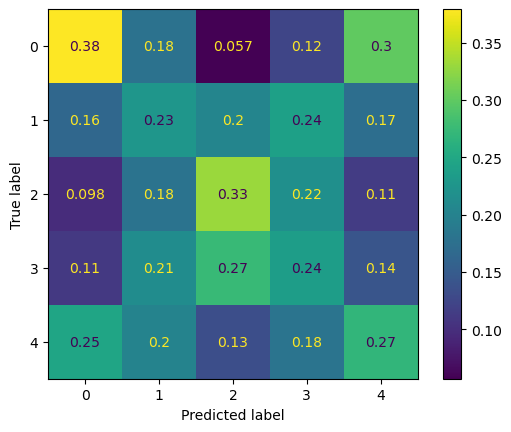

In [31]:
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=c_mats[0])
disp2 = metrics.ConfusionMatrixDisplay(confusion_matrix=c_mats_true[0])
disp.plot()
plt.savefig("ConfusionMatrixPredNorm.jpg", format="jpg", dpi=300)
plt.show()

#this plot is normalized across predicted values, meaning that out of the predicted quintiles, what is distribution into quintiles

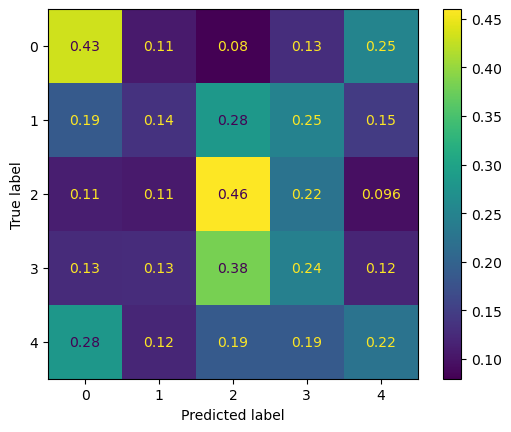

In [32]:
disp2.plot()
plt.savefig("ConfusionMatrixTrueNorm.jpg", format="jpg", dpi=300)
plt.show()

#this plot is normalized across true values, which means that out of the true quintniles, what is distr of predicted

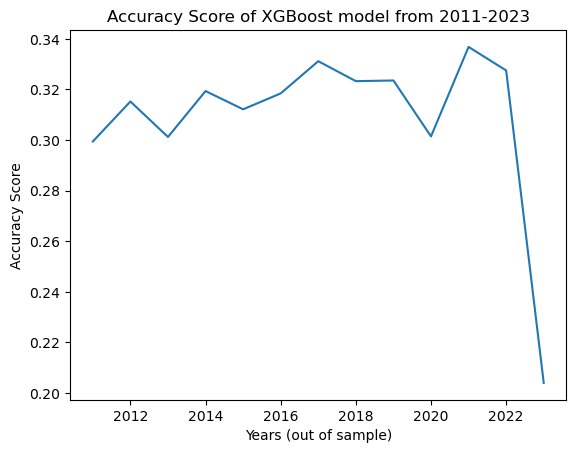

In [33]:
#2023 is all short for some reason, I think it's cuz of less data or something
years = [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
acc_scores = [m11, m12, m13, m14, m15, m16, m17, m18, m19, m20, m21, m22, m23]
plt.plot(years, acc_scores)
plt.xlabel("Years (out of sample)")
plt.ylabel("Accuracy Score")
plt.title("Accuracy Score of XGBoost model from 2011-2023")
plt.savefig("AccuracyScore.jpg", format="jpg", dpi=300)

In [34]:
pd.DataFrame(acc_scores).sum()/len(acc_scores)

0    0.30872
dtype: float64

In [35]:
ret_2011_biased = gen_returns_biased(to_intersect("2011Test.csv", df_returns), Y_2011_pred)
ret_2012_biased = gen_returns_biased(to_intersect("2012Test.csv", df_returns), Y_2012_pred)
ret_2013_biased = gen_returns_biased(to_intersect("2013Test.csv", df_returns), Y_2013_pred)
ret_2014_biased = gen_returns_biased(to_intersect("2014Test.csv", df_returns), Y_2014_pred)
ret_2015_biased = gen_returns_biased(to_intersect("2015Test.csv", df_returns), Y_2015_pred)
ret_2016_biased = gen_returns_biased(to_intersect("2016Test.csv", df_returns), Y_2016_pred)
ret_2017_biased = gen_returns_biased(to_intersect("2017Test.csv", df_returns), Y_2017_pred)
ret_2018_biased = gen_returns_biased(to_intersect("2018Test.csv", df_returns), Y_2018_pred)
ret_2019_biased = gen_returns_biased(to_intersect("2019Test.csv", df_returns), Y_2019_pred)
ret_2020_biased = gen_returns_biased(to_intersect("2020Test.csv", df_returns), Y_2020_pred)
ret_2021_biased = gen_returns_biased(to_intersect("2021Test.csv", df_returns), Y_2021_pred)
ret_2022_biased = gen_returns_biased(to_intersect("2022Test.csv", df_returns), Y_2022_pred)
ret_2023_biased = gen_returns_biased(to_intersect("2023Test.csv", df_returns), Y_2023_pred)
ret_biased = [ret_2011_biased, ret_2012_biased, ret_2013_biased, ret_2014_biased, ret_2015_biased, ret_2016_biased, ret_2017_biased, ret_2018_biased, ret_2019_biased, ret_2020_biased, ret_2021_biased, ret_2022_biased, ret_2023_biased]

/var/folders/sz/ts8tdp9n3f133bj7r6__4w7h0000gn/T/ipykernel_38699/1325193076.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfRET =  dfRET[df_returns["date"]<=df['yyyymm'].max()]


NameError: name 'take_positions_biased' is not defined

In [ ]:
ret_2011 = gen_returns(to_intersect("2011Test.csv", df_returns), Y_2011_pred)
ret_2012 = gen_returns(to_intersect("2012Test.csv", df_returns), Y_2012_pred)
ret_2013 = gen_returns(to_intersect("2013Test.csv", df_returns), Y_2013_pred)
ret_2014 = gen_returns(to_intersect("2014Test.csv", df_returns), Y_2014_pred)
ret_2015 = gen_returns(to_intersect("2015Test.csv", df_returns), Y_2015_pred)
ret_2016 = gen_returns(to_intersect("2016Test.csv", df_returns), Y_2016_pred)
ret_2017 = gen_returns(to_intersect("2017Test.csv", df_returns), Y_2017_pred)
ret_2018 = gen_returns(to_intersect("2018Test.csv", df_returns), Y_2018_pred)
ret_2019 = gen_returns(to_intersect("2019Test.csv", df_returns), Y_2019_pred)
ret_2020 = gen_returns(to_intersect("2020Test.csv", df_returns), Y_2020_pred)
ret_2021 = gen_returns(to_intersect("2021Test.csv", df_returns), Y_2021_pred)
ret_2022 = gen_returns(to_intersect("2022Test.csv", df_returns), Y_2022_pred)
ret_2023 = gen_returns(to_intersect("2023Test.csv", df_returns), Y_2023_pred)
returns = [ret_2011, ret_2012, ret_2013, ret_2014, ret_2015, ret_2016, ret_2017, ret_2018, ret_2019, ret_2020, ret_2021, ret_2022, ret_2023]

In [ ]:
ret_2011_ranked = gen_returns_ranked(to_intersect("2011Test.csv", df_returns), Y_2011_pred)
ret_2012_ranked = gen_returns_ranked(to_intersect("2012Test.csv", df_returns), Y_2012_pred)
ret_2013_ranked = gen_returns_ranked(to_intersect("2013Test.csv", df_returns), Y_2013_pred)
ret_2014_ranked = gen_returns_ranked(to_intersect("2014Test.csv", df_returns), Y_2014_pred)
ret_2015_ranked = gen_returns_ranked(to_intersect("2015Test.csv", df_returns), Y_2015_pred)
ret_2016_ranked = gen_returns_ranked(to_intersect("2016Test.csv", df_returns), Y_2016_pred)
ret_2017_ranked = gen_returns_ranked(to_intersect("2017Test.csv", df_returns), Y_2017_pred)
ret_2018_ranked = gen_returns_ranked(to_intersect("2018Test.csv", df_returns), Y_2018_pred)
ret_2019_ranked = gen_returns_ranked(to_intersect("2019Test.csv", df_returns), Y_2019_pred)
ret_2020_ranked = gen_returns_ranked(to_intersect("2020Test.csv", df_returns), Y_2020_pred)
ret_2021_ranked = gen_returns_ranked(to_intersect("2021Test.csv", df_returns), Y_2021_pred)
ret_2022_ranked = gen_returns_ranked(to_intersect("2022Test.csv", df_returns), Y_2022_pred)
ret_2023_ranked = gen_returns_ranked(to_intersect("2023Test.csv", df_returns), Y_2023_pred)
returns_ranked = [ret_2011_ranked, ret_2012_ranked, ret_2013_ranked, ret_2014_ranked, ret_2015_ranked, ret_2016_ranked, ret_2017_ranked, ret_2018_ranked, ret_2019_ranked, ret_2020_ranked, ret_2021_ranked, ret_2022_ranked, ret_2023_ranked]

In [ ]:
returns_ranked

In [ ]:
sharpes = []
sharpes_biased = []
sharpes_ranked = []
drawdowns = []
for i in returns:
    sharpes.append(sharpe_ratio(i))
    
for i in ret_biased:
    sharpes_biased.append(sharpe_ratio(i))
    
for i in returns_ranked:
    sharpes_ranked.append(sharpe_ratio(i))
    
average_sharpe = sum(sharpes)/len(sharpes)
average_sharpe_biased = sum(sharpes_biased)/len(sharpes_biased)
average_sharpe_ranked = sum(sharpes_ranked)/len(sharpes_ranked)

for i in returns:
    drawdowns.append(drawdown(i))
average_drawdown = sum(drawdowns)/len(drawdowns)    
years = [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
print(average_sharpe)
print(average_sharpe_biased)
print(average_sharpe_ranked)
print(average_drawdown)
plt.plot(years, sharpes, label="Market Neutral Long Top, Short Bottom" )
plt.plot(years, sharpes_ranked, label="Ranked Portfolio")
plt.plot(years, sharpes_biased, label="Long Top Quintile, Short Bottom Quintile")
plt.xlabel("Years (Out of Sample)")
plt.ylabel("Annual Sharpe Ratio")
plt.title("Annual Sharpe Ratios for our three portfolios from 2011 to 2023")
plt.legend()
plt.savefig('XGSharpes.jpg', format='jpg', dpi=300) 

In [ ]:
Y_2010_pred = xgc_recent.predict(X_2010)
metrics.accuracy_score(Y_2010_pred, Y_2010)

In [ ]:
def take_positions(intersection, Y_pred):    
    pos=[]
    for i in range(0, len(intersection)):
        if Y_pred[i] == 0:
            pos.append(-1)
        elif Y_pred[i] == 4:
            pos.append(1)
        else:
            pos.append(0)
    pos = pd.DataFrame(pos)
    total_short = sum(pos==-1)
    total_long = sum(pos==1)
    if total_short > total_long:
        for i in range(0, len(pos)):
            if i==-1:
                pos[i]*(total_long/total_short)
    if total_long > total_short:
        for i in range(0, len(pos)):
            if i==1:
                pos[i]*(total_short/total_long)
    return pos

def take_positions_ranked(intersection, Y_pred):    
    pos=[]
    for i in range(0, len(intersection)):
        if Y_pred[i] == 0:
            pos.append(-1)
        elif Y_pred[i] == 1:
            pos.append(-0.5)
        elif Y_pred[i]==2:
            pos.append(0)
        elif Y_pred[i]==3:
            pos.append(0.5)
        elif Y_pred[i] == 4:
            pos.append(1)
        else:
            pos.append(0)
    return pos

def take_positions_biased(intersection, Y_pred):    
    pos=[]
    for i in range(0, len(intersection)):
        if Y_pred[i] == 0:
            pos.append(-1)
        elif Y_pred[i] == 4:
            pos.append(1)
        else:
            pos.append(0)
    return pos
#intersection_df_2010.insert(0, "Positions", take_positions(intersection_df_2010, Y_2010_pred), False)

In [46]:
pivoted_2010 = intersection_df_2010.pivot_table(index='date', columns='permno', values='Positions', aggfunc='mean')
pivoted_ret_2010 = intersection_df_2010.pivot_table(index='date', columns='permno', values='RET', aggfunc='mean')
xg_recent_ret_2010 = returns_from_positions(pivoted_2010, pivoted_ret_2010)

KeyError: 'Positions'

In [ ]:
sharpe_ratio(xg_recent_ret_2010)

In [ ]:
long_return_2010 = pivoted_ret_2010.sum(axis=1)
long_return_2010

In [25]:
df1.rename(columns={'yyyymm': 'date'}, inplace=True)

In [26]:
intersection_df = pd.merge(df1, df_returns_train, how='inner', on=['permno', 'date'])

In [27]:
intersection_df['Year'] = intersection_df['date'].dt.year
intersection_df['Month'] = intersection_df['date'].dt.month
intersection_df['RET'] = pd.to_numeric(intersection_df["RET"], errors='coerce')

In [28]:
intersection_df['Quintile'] = intersection_df.groupby(['Year', 'Month'])['RET'].transform(
    lambda x: pd.qcut(x, 5, labels=False)
)

intersection_df.dropna(subset = ['Quintile'], inplace=True)

In [29]:
drop_from_df = ["permno", "date", "RET", "RETX", "Quintile", "Year", "Date", "Month", "Unnamed: 0.2", "Unnamed: 0.1", "Unnamed: 0"]
Y = intersection_df["Quintile"]
X = intersection_df.drop(columns=drop_from_df)

In [30]:
xgc.fit(X, Y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
#scrape the validation set
#df_valid = pd.read_csv("Firm Level Characteristics/Full Sets/signed_predictors_dl_wide.csv")

In [ ]:
#df_valid = df_valid[df_valid["yyyymm"]>= 197001]
#df_valid = df_valid[df_valid['yyyymm']<=197212]

In [31]:
df_valid = pd.read_csv("1970-1973Validation.csv")
df_valid['yyyymm'] = pd.to_datetime(df_valid['yyyymm'],format = "%Y%m")
df_valid['yyyymm'] = df_valid['yyyymm'].apply(lambda dt: dt.replace(day=1))


FileNotFoundError: [Errno 2] No such file or directory: '1970-1973Validation.csv'

In [ ]:
df_valid_returns = df_returns[df_returns["date"] >= "1970-01-01"]
df_valid_returns = df_valid_returns[df_valid_returns["date"] < "1973-01-01"]

In [ ]:
df_valid_returns.rename(columns={"PERMNO": "permno"}, inplace=True)
df_valid.rename(columns={'yyyymm': 'date'}, inplace=True)


In [ ]:
intersection_valid = pd.merge(df_valid, df_valid_returns, how='inner', on=['permno', 'date'])

In [ ]:
intersection_valid['Year'] = intersection_valid['date'].dt.year
intersection_valid['Month'] = intersection_valid['date'].dt.month
intersection_valid['RET'] = pd.to_numeric(intersection_valid["RET"], errors='coerce')

intersection_valid['Quintile'] = intersection_valid.groupby(['Year', 'Month'])['RET'].transform(
    lambda x: pd.qcut(x, 5, labels=False)
)

intersection_valid.dropna(subset = ['Quintile'], inplace=True)

drop_from_df_valid = ["permno", "date", "RET", "RETX", "Quintile", "Year", "Month", "Unnamed: 0"]
Y_valid = intersection_valid["Quintile"]
X_valid = intersection_valid.drop(columns=drop_from_df_valid)

In [ ]:
Y_valid_pred = xgc.predict(X_valid)

In [ ]:
metrics.accuracy_score(Y_valid, Y_valid_pred)

In [ ]:
#look into ordinal classification since we're only L/S off of top and bottom quintile
#backtest this model
#group parameters together
#fine tune hyperparameters

In [ ]:
#maybe do clustering for features using X matrix
X

In [ ]:
category_dict = df.groupby('Cat.Economic')['Acronym'].apply(list).to_dict()
# Assuming df is your DataFrame
# Initialize a new DataFrame to hold aggregated features
aggregated_features = pd.DataFrame(index=intersection_df.index)

# Loop through each group and aggregate features
for group, features in category_dict.items():
    # Example: Taking the mean as an aggregation method
    new_features = list(set(intersection_df.columns.values) & set(features))
    aggregated_features[group] = intersection_df[new_features].median(axis=1, skipna=True)


In [ ]:
aggregated_features.columns.values

In [ ]:
xgc.fit(aggregated_features, Y)

In [ ]:
aggregated_features_valid = pd.DataFrame(index=intersection_valid.index)
#try normalization
for group, features in category_dict.items():
    # Example: Taking the mean as an aggregation method
    new_features = list(set(intersection_valid.columns.values) & set(features))
    aggregated_features_valid[group] = intersection_valid[new_features].mean(axis=1, skipna=True)

In [ ]:
Y_agg_pred = xgc.predict(aggregated_features_valid)

In [ ]:
metrics.accuracy_score(Y_agg_pred, Y_valid)

In [ ]:
#fine tuning hyperparams
#0.4222528519240682 benchmark score
xgc_tune = XGBClassifier(gamma = 0.8)
xgc_tune.fit(X, Y)
Y_valid_pred_tune = xgc_tune.predict(X_valid)
metrics.accuracy_score(Y_valid, Y_valid_pred_tune)

In [ ]:
#import matplotlib.pyplot as plt
#for i in range(1, 8):
    #xgc_depth = XGBClassifier(max_depth=i)
    #xgc_depth.fit(X,Y)
    #Y_valid_pred_depth = xgc_depth.predict(X_valid)
    #print(str(i)+", "+str(metrics.accuracy_score(Y_valid, Y_valid_pred_depth)))

In [ ]:
#for i in range(0, 21, 5):
#    xgc_gamma = XGBClassifier(gamma=(i/10))
#    xgc_gamma.fit(X,Y)
#    Y_valid_pred_gamma = xgc_gamma.predict(X_valid)
#    print(str(i/10)+", "+str(metrics.accuracy_score(Y_valid, Y_valid_pred_gamma)))

In [ ]:
#for i in range(1, 10):
#    xgc_lambda = XGBClassifier(reg_lambda = i)
#    xgc_lambda.fit(X,Y)
#    Y_valid_pred_lambda = xgc_lambda.predict(X_valid)
#    print(str(i)+ ", " + str(metrics.accuracy_score(Y_valid, Y_valid_pred_lambda)))

In [ ]:
xgc_tune_final = XGBClassifier(max_depth = 5, gamma = 1.5, reg_lambda=7)
xgc_tune_final.fit(X,Y)
Y_valid_pred_final = xgc_tune_final.predict(X_valid)
metrics.accuracy_score(Y_valid, Y_valid_pred_lambda)

In [ ]:
df = df[df["Cat.Signal"] == "Predictor"]

In [ ]:
df

In [ ]:
category_dict = df.groupby('Cat.Economic')['Acronym'].apply(list).to_dict()

In [ ]:
category_dict

In [ ]:
#break up csv file into smaller chunks so I can test/train/valid on different years
#normalize data to grouping --> finished

In [ ]:
pos=[]
for i in range(0, len(intersection_valid)):
    if Y_valid_pred[i] == 0:
        pos.append(-1)
    elif Y_valid_pred[i] == 4:
        pos.append(1)
    else:
        pos.append(0)
        
sum(pos)
        

#intersection_valid.insert(0, "Positions", pos, False)

In [ ]:

pivoted_valid = intersection_valid.pivot_table(index='date', columns='permno', values='Positions', aggfunc='mean')

In [ ]:
pivoted_valid

In [ ]:
#create panel data of returns
pivoted_ret = intersection_valid.pivot_table(index='date', columns='permno', values='RET', aggfunc='mean')

In [ ]:
pivoted_ret

In [ ]:
xg_return = returns_from_positions(pivoted_valid, pivoted_ret)

In [ ]:
xg_return

In [ ]:
norm_return = pivoted_ret.sum(axis=1)

In [ ]:
norm_return

In [ ]:
#normalize positions so it's market neutral
#grouped and ungrouped--> rewrite normalization code and record it
#see difference in predictions
#pull data for the 2000s

In [55]:
#2011 splits
def take_positions_breakdown(intersection, Y_pred):    
    pos_0=[]
    pos_1=[]
    pos_3=[]
    pos_4=[]
    for i in range(0, len(intersection)):
        if Y_pred[i] == 0:
            pos_0.append(-1)
        else:
            pos_0.append(0)
        if Y_pred[i] == 1:
            pos_1.append(-0.5)
        else:
            pos_1.append(0)
        if Y_pred[i]==3:
            pos_3.append(0.5)
        else:
            pos_3.append(0)
        if Y_pred[i] == 4:
            pos_4.append(1)
        else:
            pos_4.append(0)
        

    return [pos_0, pos_1, pos_3, pos_4]

In [56]:
def gen_returns_breakdown(intersect, Y_pred):
    p = take_positions_breakdown(intersect, Y_pred)
    intersect.insert(0, "Positions_0", p[0], False)
    intersect.insert(0, "Positions_1", p[1], False)
    intersect.insert(0, "Positions_3", p[2], False)
    intersect.insert(0, "Positions_4", p[3], False)
    
    pivoted_0 = intersect.pivot_table(index='date', columns='permno', values='Positions_0', aggfunc='mean')
    pivoted_1 = intersect.pivot_table(index='date', columns='permno', values='Positions_1', aggfunc='mean')
    pivoted_3 = intersect.pivot_table(index='date', columns='permno', values='Positions_3', aggfunc='mean')
    pivoted_4 = intersect.pivot_table(index='date', columns='permno', values='Positions_4', aggfunc='mean')
    
    pivoted_ret = intersect.pivot_table(index='date', columns='permno', values='New RET', aggfunc='mean')
    return [returns_from_positions(pivoted_0, pivoted_ret), returns_from_positions(pivoted_1, pivoted_ret), returns_from_positions(pivoted_3, pivoted_ret), returns_from_positions(pivoted_4, pivoted_ret)]

In [57]:
ret_2011_breakdown = gen_returns_breakdown(to_intersect("2011Test.csv", df_returns), Y_2011_pred)
ret_2012_breakdown = gen_returns_breakdown(to_intersect("2012Test.csv", df_returns), Y_2012_pred)
ret_2013_breakdown = gen_returns_breakdown(to_intersect("2013Test.csv", df_returns), Y_2013_pred)
ret_2014_breakdown = gen_returns_breakdown(to_intersect("2014Test.csv", df_returns), Y_2014_pred)
ret_2015_breakdown = gen_returns_breakdown(to_intersect("2015Test.csv", df_returns), Y_2015_pred)
ret_2016_breakdown = gen_returns_breakdown(to_intersect("2016Test.csv", df_returns), Y_2016_pred)
ret_2017_breakdown = gen_returns_breakdown(to_intersect("2017Test.csv", df_returns), Y_2017_pred)
ret_2018_breakdown = gen_returns_breakdown(to_intersect("2018Test.csv", df_returns), Y_2018_pred)
ret_2019_breakdown = gen_returns_breakdown(to_intersect("2019Test.csv", df_returns), Y_2019_pred)
ret_2020_breakdown = gen_returns_breakdown(to_intersect("2020Test.csv", df_returns), Y_2020_pred)
ret_2021_breakdown = gen_returns_breakdown(to_intersect("2021Test.csv", df_returns), Y_2021_pred)
ret_2022_breakdown = gen_returns_breakdown(to_intersect("2022Test.csv", df_returns), Y_2022_pred)
ret_2023_breakdown = gen_returns_breakdown(to_intersect("2023Test.csv", df_returns), Y_2023_pred)

/var/folders/sz/ts8tdp9n3f133bj7r6__4w7h0000gn/T/ipykernel_90269/1325193076.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfRET =  dfRET[df_returns["date"]<=df['yyyymm'].max()]
/var/folders/sz/ts8tdp9n3f133bj7r6__4w7h0000gn/T/ipykernel_90269/1325193076.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfRET =  dfRET[df_returns["date"]<=df['yyyymm'].max()]
/var/folders/sz/ts8tdp9n3f133bj7r6__4w7h0000gn/T/ipykernel_90269/1325193076.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfRET =  dfRET[df_returns["date"]<=df['yyyymm'].max()]
/var/folders/sz/ts8tdp9n3f133bj7r6__4w7h0000gn/T/ipykernel_90269/1325193076.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfRET =  dfRET[df_returns["date"]<=df['yyyymm'].max()]
/var/folders/sz/ts8tdp9n3f133bj7r6__4w7h0000gn/T/ipykernel_90269/1325193076.py:7: UserWarning: Boolean Series key will be reindexed to match

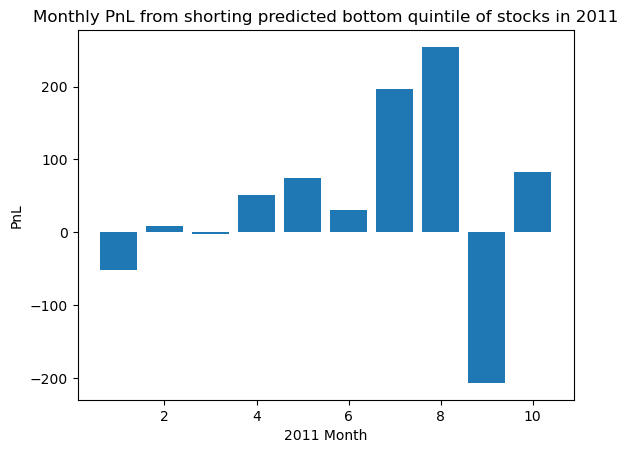

In [58]:
plt.bar([1,2,3,4,5,6,7,8,9,10], ret_2011_breakdown[0])
plt.xlabel("2011 Month")
plt.ylabel("PnL")
plt.title("Monthly PnL from shorting predicted bottom quintile of stocks in 2011")
plt.savefig("RankedPortBottom.jpg", format="jpg", dpi=300)

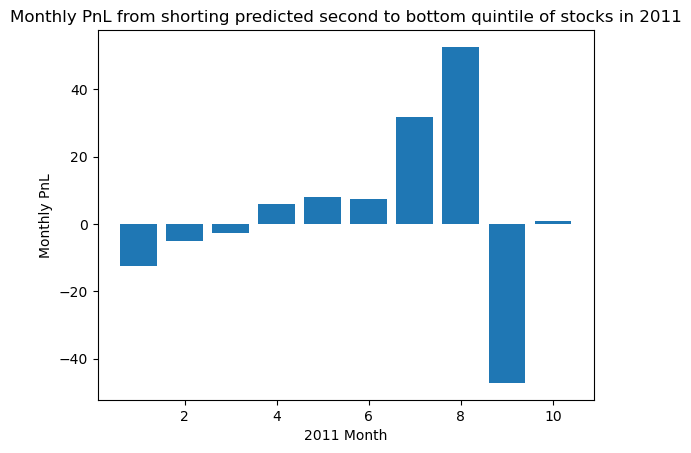

In [59]:
plt.bar([1,2,3,4,5,6,7,8,9,10], ret_2011_breakdown[1])
plt.xlabel("2011 Month")
plt.ylabel("Monthly PnL")
plt.title("Monthly PnL from shorting predicted second to bottom quintile of stocks in 2011")
plt.savefig("RankedPortSecondBottom.jpg", format="jpg", dpi=300)

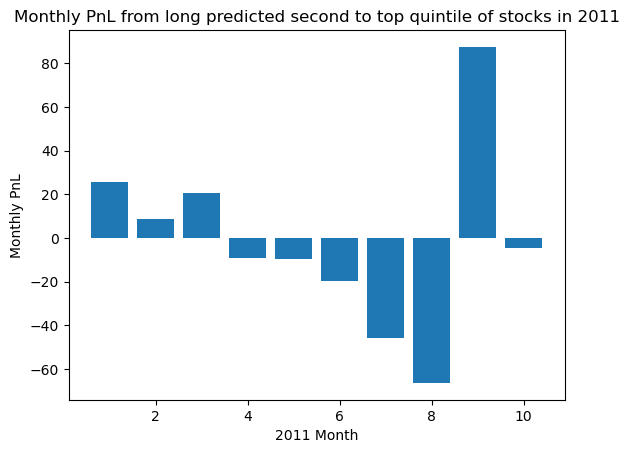

In [60]:
plt.bar([1,2,3,4,5,6,7,8,9,10], ret_2011_breakdown[2])
plt.xlabel("2011 Month")
plt.ylabel("Monthly PnL")
plt.title("Monthly PnL from long predicted second to top quintile of stocks in 2011")
plt.savefig("RankedPortSecondTop.jpg", format="jpg", dpi=300)

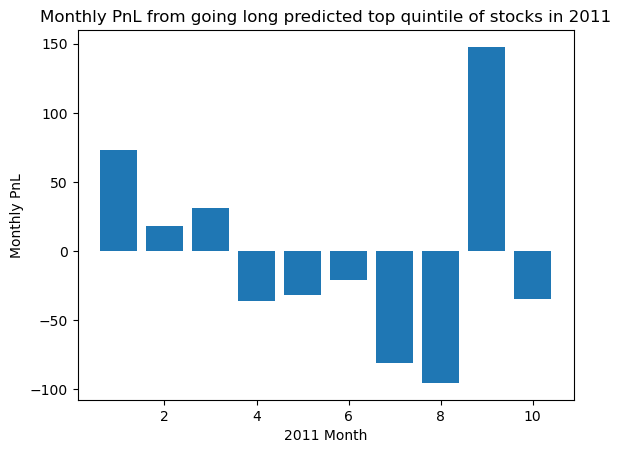

In [61]:
plt.bar([1,2,3,4,5,6,7,8,9,10], ret_2011_breakdown[3])
plt.xlabel("2011 Month")
plt.ylabel("Monthly PnL")
plt.title("Monthly PnL from going long predicted top quintile of stocks in 2011")
plt.savefig("RanekdPortTop.jpg", format="jpg", dpi=300)

In [62]:
r_11 = []
for i in ret_2011_breakdown:
    r_11.append(i.sum())

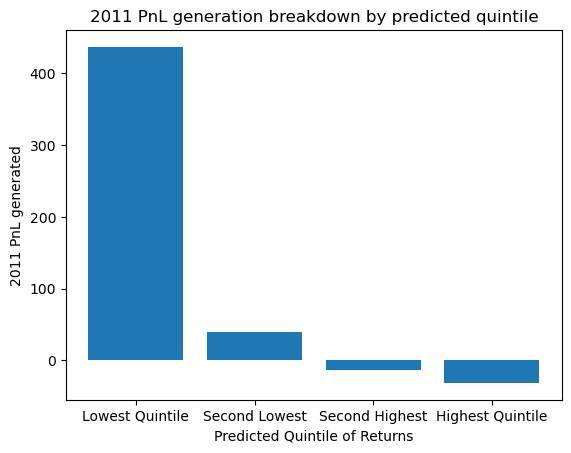

In [63]:
plt.bar(["Lowest Quintile", "Second Lowest", "Second Highest", "Highest Quintile"], r_11)
plt.xlabel("Predicted Quintile of Returns")
plt.ylabel("2011 PnL generated")
plt.title("2011 PnL generation breakdown by predicted quintile")
plt.savefig("RankedPortPnLBreakdown.jpg", format="jpg", dpi=300)

In [64]:
r_12 = []
for i in ret_2012_breakdown:
    r_12.append(i.sum())

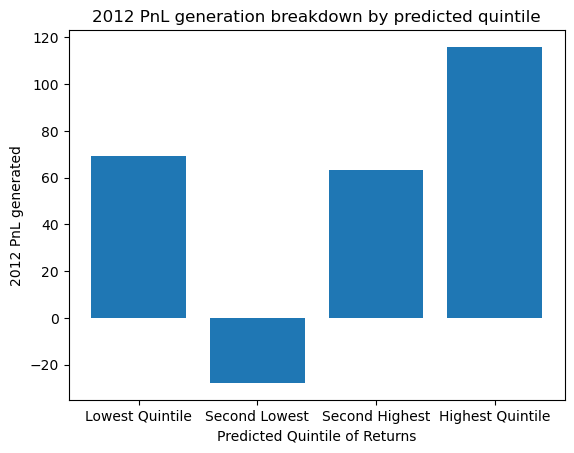

In [65]:
plt.bar(["Lowest Quintile", "Second Lowest", "Second Highest", "Highest Quintile"], r_12)
plt.xlabel("Predicted Quintile of Returns")
plt.ylabel("2012 PnL generated")
plt.title("2012 PnL generation breakdown by predicted quintile")
plt.savefig("RankedPortPnLBreakdown.jpg", format="jpg", dpi=300)

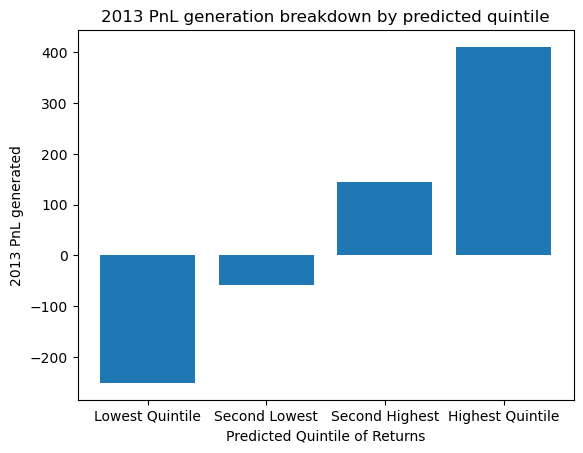

In [66]:
r_13 = []
for i in ret_2013_breakdown:
    r_13.append(i.sum())

plt.bar(["Lowest Quintile", "Second Lowest", "Second Highest", "Highest Quintile"], r_13)
plt.xlabel("Predicted Quintile of Returns")
plt.ylabel("2013 PnL generated")
plt.title("2013 PnL generation breakdown by predicted quintile")
plt.savefig("RankedPortPnLBreakdown.jpg", format="jpg", dpi=300)

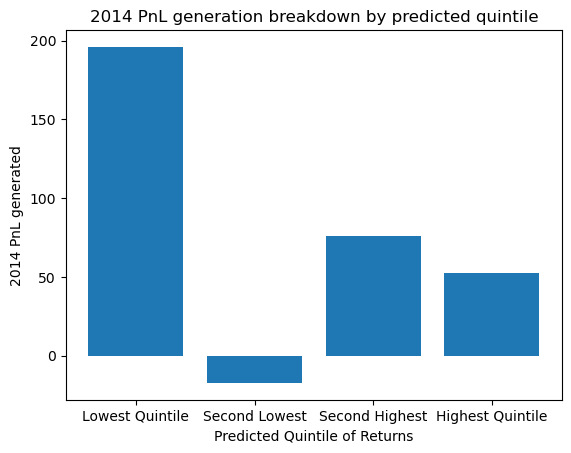

In [67]:
r_14 = []
for i in ret_2014_breakdown:
    r_14.append(i.sum())

plt.bar(["Lowest Quintile", "Second Lowest", "Second Highest", "Highest Quintile"], r_14)
plt.xlabel("Predicted Quintile of Returns")
plt.ylabel("2014 PnL generated")
plt.title("2014 PnL generation breakdown by predicted quintile")
plt.savefig("RankedPortPnLBreakdown.jpg", format="jpg", dpi=300)

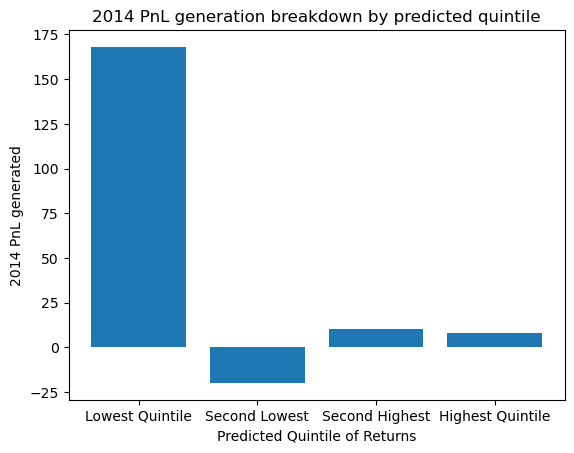

In [68]:
r_15 = []
for i in ret_2015_breakdown:
    r_15.append(i.sum())

plt.bar(["Lowest Quintile", "Second Lowest", "Second Highest", "Highest Quintile"], r_15)
plt.xlabel("Predicted Quintile of Returns")
plt.ylabel("2014 PnL generated")
plt.title("2014 PnL generation breakdown by predicted quintile")
plt.savefig("RankedPortPnLBreakdown.jpg", format="jpg", dpi=300)

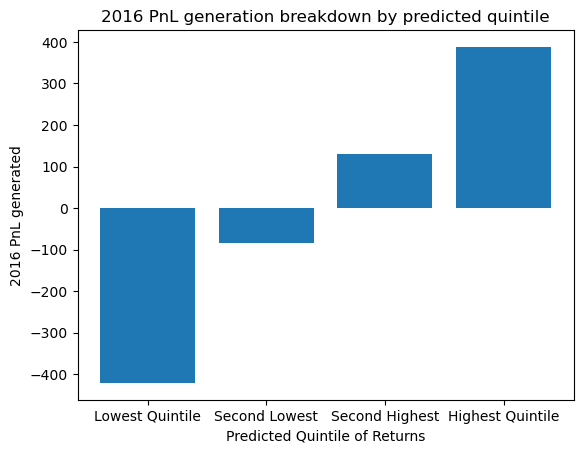

In [69]:
r_16 = []
for i in ret_2016_breakdown:
    r_16.append(i.sum())

plt.bar(["Lowest Quintile", "Second Lowest", "Second Highest", "Highest Quintile"], r_16)
plt.xlabel("Predicted Quintile of Returns")
plt.ylabel("2016 PnL generated")
plt.title("2016 PnL generation breakdown by predicted quintile")
plt.savefig("RankedPortPnLBreakdown.jpg", format="jpg", dpi=300)

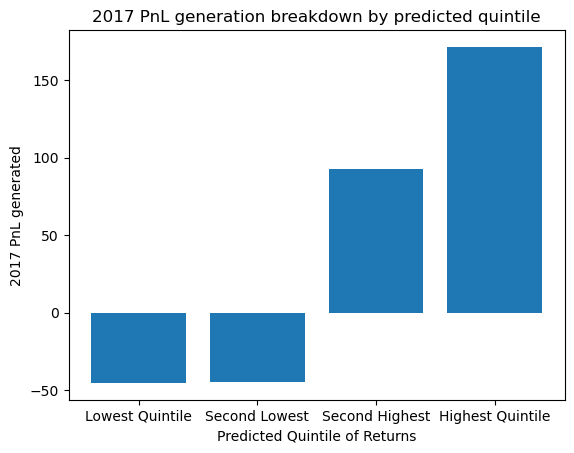

In [70]:
r_17 = []
for i in ret_2017_breakdown:
    r_17.append(i.sum())

plt.bar(["Lowest Quintile", "Second Lowest", "Second Highest", "Highest Quintile"], r_17)
plt.xlabel("Predicted Quintile of Returns")
plt.ylabel("2017 PnL generated")
plt.title("2017 PnL generation breakdown by predicted quintile")
plt.savefig("RankedPortPnLBreakdown.jpg", format="jpg", dpi=300)

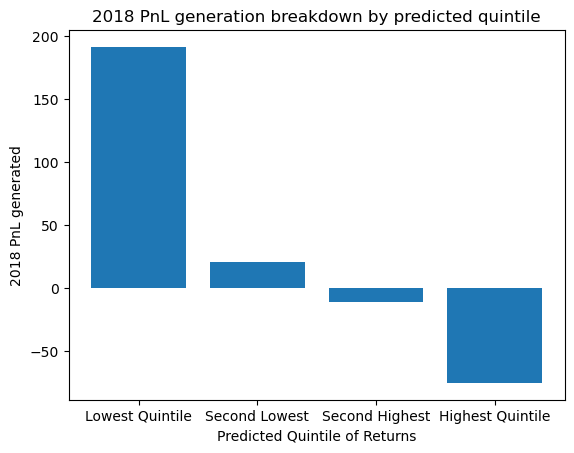

In [71]:
r_18 = []
for i in ret_2018_breakdown:
    r_18.append(i.sum())

plt.bar(["Lowest Quintile", "Second Lowest", "Second Highest", "Highest Quintile"], r_18)
plt.xlabel("Predicted Quintile of Returns")
plt.ylabel("2018 PnL generated")
plt.title("2018 PnL generation breakdown by predicted quintile")
plt.savefig("RankedPortPnLBreakdown.jpg", format="jpg", dpi=300)

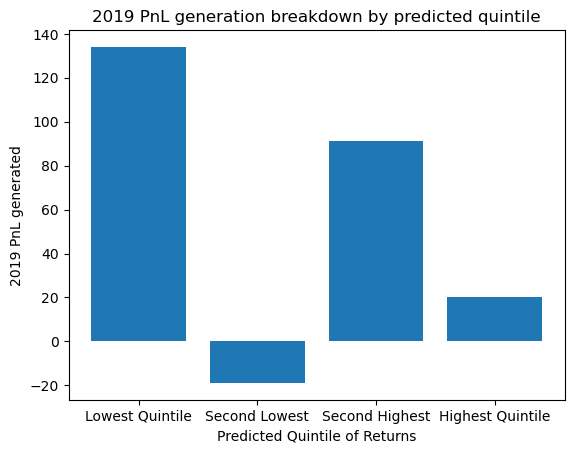

In [72]:
r_19 = []
for i in ret_2019_breakdown:
    r_19.append(i.sum())

plt.bar(["Lowest Quintile", "Second Lowest", "Second Highest", "Highest Quintile"], r_19)
plt.xlabel("Predicted Quintile of Returns")
plt.ylabel("2019 PnL generated")
plt.title("2019 PnL generation breakdown by predicted quintile")
plt.savefig("RankedPortPnLBreakdown.jpg", format="jpg", dpi=300)

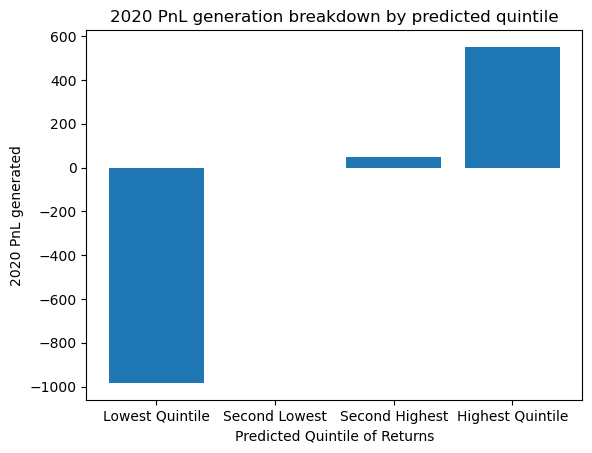

In [73]:
r_20 = []
for i in ret_2020_breakdown:
    r_20.append(i.sum())

plt.bar(["Lowest Quintile", "Second Lowest", "Second Highest", "Highest Quintile"], r_20)
plt.xlabel("Predicted Quintile of Returns")
plt.ylabel("2020 PnL generated")
plt.title("2020 PnL generation breakdown by predicted quintile")
plt.savefig("RankedPortPnLBreakdown.jpg", format="jpg", dpi=300)

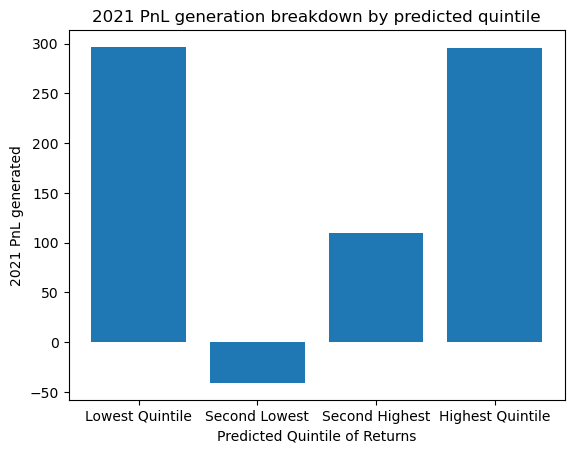

In [74]:
r_21 = []
for i in ret_2021_breakdown:
    r_21.append(i.sum())

plt.bar(["Lowest Quintile", "Second Lowest", "Second Highest", "Highest Quintile"], r_21)
plt.xlabel("Predicted Quintile of Returns")
plt.ylabel("2021 PnL generated")
plt.title("2021 PnL generation breakdown by predicted quintile")
plt.savefig("RankedPortPnLBreakdown.jpg", format="jpg", dpi=300)

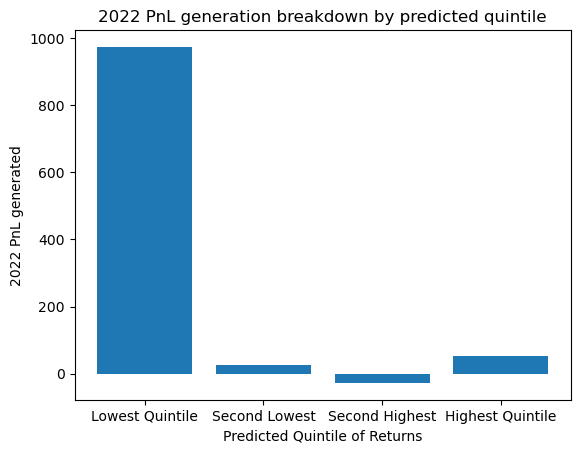

In [75]:
r_22 = []
for i in ret_2022_breakdown:
    r_22.append(i.sum())

plt.bar(["Lowest Quintile", "Second Lowest", "Second Highest", "Highest Quintile"], r_22)
plt.xlabel("Predicted Quintile of Returns")
plt.ylabel("2022 PnL generated")
plt.title("2022 PnL generation breakdown by predicted quintile")
plt.savefig("RankedPortPnLBreakdown.jpg", format="jpg", dpi=300)

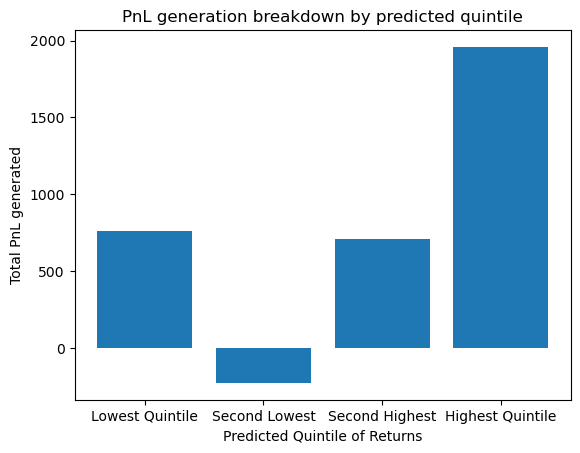

In [76]:
r_breakdowns = [r_11, r_12, r_13, r_14, r_15, r_16, r_17, r_18, r_19, r_20, r_21, r_22]
low = 0
s_low = 0
s_high = 0
high = 0

for i in r_breakdowns:
    low+=i[0]
    s_low+=i[1]
    s_high+=i[2]
    high+=i[3]

plt.bar(["Lowest Quintile", "Second Lowest", "Second Highest", "Highest Quintile"], [low, s_low, s_high, high])
plt.xlabel("Predicted Quintile of Returns")
plt.ylabel("Total PnL generated")
plt.title("PnL generation breakdown by predicted quintile")
plt.savefig("RankedPortPnLBreakdown.jpg", format="jpg", dpi=300)

In [45]:
import shap

In [ ]:
# compute SHAP values
background_adult = shap.maskers.Independent(X_recent, max_samples=10)
explainer = shap.Explainer(xgc_recent, background_adult)
shap_values = explainer(X_recent, check_additivity=False)

# set a display version of the data to use for plotting (has string values)


In [ ]:
explain = shap.TreeExplainer(xgc_recent)
explanation = explain(X_recent)

In [ ]:
shap.plots.bar(shap_values)

In [20]:
xgc_recent.features_importances_

AttributeError: 'XGBClassifier' object has no attribute 'features_importances_'

In [3]:
from xgboost import plot_importance
from xgboost import plot_tree
from xgboost import to_graphviz

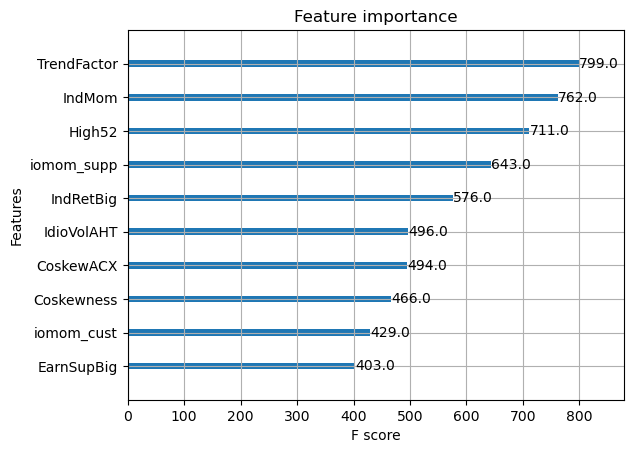

In [40]:
plot_importance(xgc_recent, max_num_features=10)
plt.savefig("Feature_importance_Count.jpg", format="jpg", dpi=300)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

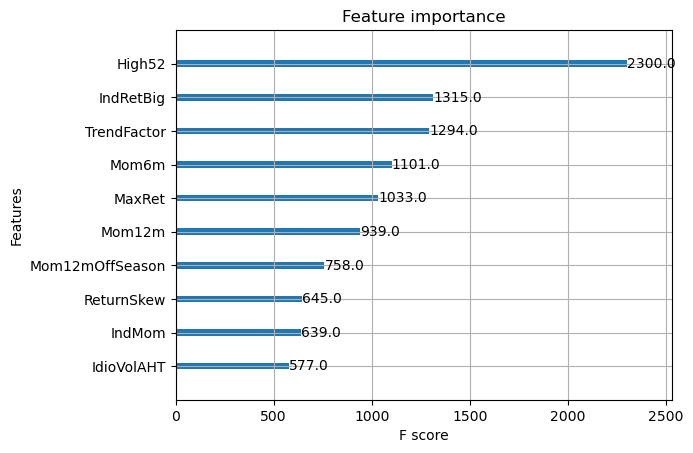

In [38]:
plot_importance(xgc, max_num_features=10)


In [ ]:
plot_tree(xgc, num_trees=10, ax=ax)

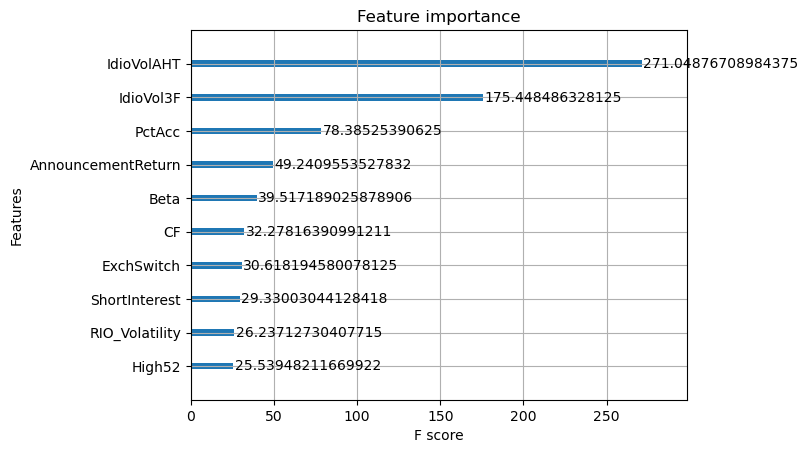

In [42]:
plot_importance(xgc_recent, max_num_features=10, importance_type="gain")
plt.savefig("Feature_importance_Gain.jpg", format="jpg", dpi=300)

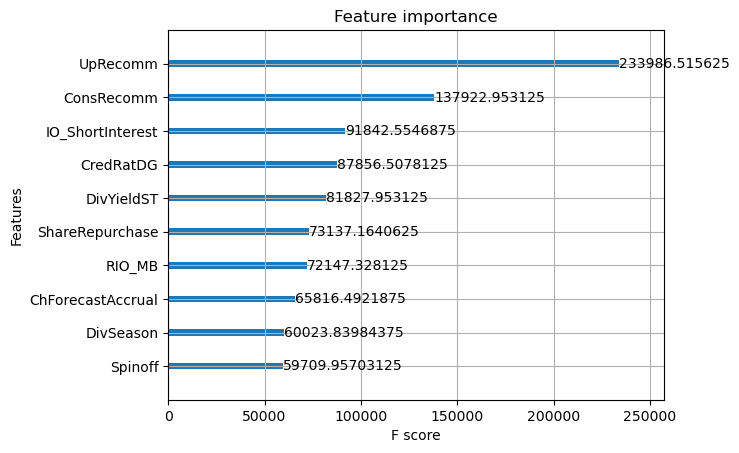

In [43]:
plot_importance(xgc_recent, max_num_features=10, importance_type="cover")
plt.savefig("Feature_importance_Cover.jpg", format="jpg", dpi=300)